In [2]:
import numpy as np 
import sys
sys.path.append('/global/u1/j/jelvinpo/DES/lss_sys/') # DES LSS toolkit from https://github.com/des-science/lss_sys
sys.path.insert(0, '/global/u1/j/jelvinpo/DES/2point/' )
import lsssys
import twopoint
import pylab as plt 
import healpy as hp 

Reading config file
Working with Y3


In [32]:
#load y1 and y3 data

#the official y3 data vector
off_dvec_file = '/Users/jackelvinpoole/DES/y3-3x2pt/data/des-y3/2pt_NG_final_2ptunblind_10_26_20_wnz.fits'
off_dvec = twopoint.TwoPointFile.from_fits(off_dvec_file).get_spectrum('wtheta')

off_cov_full = twopoint.TwoPointFile.from_fits(off_dvec_file).covmat

#the official y3 data vector
off_y1_dvec_file = '/Users/jackelvinpoole/DES/des-mpp/data_vectors/y1/2pt_NG_mcal_1110.fits'
off_y1_dvec = twopoint.TwoPointFile.from_fits(off_y1_dvec_file).get_spectrum('wtheta')

label = 'y1_y3'

#load y3 catalog and mask 
y3_dir = '/Users/jackelvinpoole/DES/cats/y3/redmagic/combined_sample_0.5.1_wide_0.9binning_zmax0.95/'
y3_cat_file  = y3_dir+'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_combined_hd3_hl2_sample_weighted2.0sig.fits.gz'
y3_mask_dir = '/Users/jackelvinpoole/DES/cats/y3/masks/lens_sample_joint_mask/'
y3_mask_file = y3_mask_dir+'y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz'
cat_y3 = lsssys.Redmagic(y3_cat_file)
mask_y3 = lsssys.Mask(y3_mask_file)

#load y1 catalog and mask 
y1_dir = '/Users/jackelvinpoole/DES/cats/redmagic_y1_3x2pt_weighted/'
y1_cat_file = y1_dir + '5bins_hidens_hilum_higherlum_jointmask_0.15-0.9_magauto_mof_combo_removedupes_spt_fwhmi_exptimei_cut_badpix_sample_weighted2sig.fits.gz'
y1_mask_file = y1_dir + '5bins_hidens_hilum_higherlum_jointmask_0.15-0.9_magauto_mof_combo_removedupes_spt_fwhmi_exptimei_cut_badpix_mask.fits.gz'

cat_y1 = lsssys.Redmagic(y1_cat_file)
mask_y1 = lsssys.Mask(y1_mask_file)

#join the masks 
mask_y1.jointmask(mask_y3)
mask_y3.jointmask(mask_y1)

#load masks again but don;t join
mask_y1_raw = lsssys.Mask(y1_mask_file)
mask_y3_raw = lsssys.Mask(y3_mask_file)

#y3 mask with y1 pixels removed
mask_y3_not_y1 = lsssys.Mask(y3_mask_file)
inother = np.in1d(mask_y3_not_y1.maskpix, mask_y1_raw.maskpix)
mask_y3_not_y1.maskpix = mask_y3_not_y1.maskpix[~inother]
mask_y3_not_y1.fracpix = mask_y3_not_y1.fracpix[~inother]
mask_y3_not_y1.makemask()

#z bin edges to use for the two sample
# in y3 we use  [0.15, 0.35, 0.50, 0.65, 0.80, 0.90 ]
# in y1 we used [0.15, 0.30, 0.45, 0.60, 0.75, 0.90 ]
binedges_y1 = [ 0.15, 0.35, 0.50, 0.65, 0.80, 0.90 ]
binedges_y3 = [ 0.15, 0.35, 0.50, 0.65, 0.80, 0.90 ]
extra_label = 'y3binedges'

#treecorr settings
bin_slop = 0.01
thetamax = 250./60.
thetamin = 2.5/60.
nthetabins = 20
nside = 512

nbins = len(binedges_y1)-1

no ZLUM column in file
no column ZMAX. no ZMAX column loaded
no column ZMAX. no ZMAX column loaded
no column ZMAX. no ZMAX column loaded
no column ZMAX. no ZMAX column loaded
no column ZMAX. no ZMAX column loaded


In [3]:
#function to put w theta result into a dict for saving
def to_wdict(theta, w):
    w_dict = {}
    w_dict['theta'] = theta
    w_dict[0,0] = w
    
    angle_edges = np.logspace(np.log10(thetamin*60.),np.log10(thetamax*60.), 21)
    w_dict['angle_min'] = angle_edges[:-1]
    w_dict['angle_max'] = angle_edges[1:]
    return w_dict

In [4]:
#construct the galaxy density maps
#the degrading will take some time
galmaps_all = {}
skip_bins = []
for ibin in xrange(nbins):
    if ibin in skip_bins:
        continue
        
    galmaps = {}
        
    ra_y1, dec_y1, amask_y1 = cat_y1.eqinbin(binedges_y1[ibin], binedges_y1[ibin+1], returnmask=True)
    galmaps['y1'] = lsssys.cat2galmap(ra_y1, dec_y1, mask_y1_raw, weight=cat_y1.weight[amask_y1], nside=nside)
    galmaps['y1_jm'] = lsssys.cat2galmap(ra_y1, dec_y1, mask_y1, weight=cat_y1.weight[amask_y1], nside=nside)
    
    ra_y3, dec_y3, amask_y3 = cat_y3.eqinbin(binedges_y3[ibin], binedges_y3[ibin+1], returnmask=True)
    galmaps['y3'] = lsssys.cat2galmap(ra_y3, dec_y3, mask_y3_raw, weight=cat_y3.weight[amask_y3], nside=nside)
    galmaps['y3_jm'] = lsssys.cat2galmap(ra_y3, dec_y3, mask_y3, weight=cat_y3.weight[amask_y3], nside=nside)
    galmaps['y3_noty1'] = lsssys.cat2galmap(ra_y3, dec_y3, mask_y3_not_y1, weight=cat_y3.weight[amask_y3], nside=nside)

    galmaps_all[ibin+1] = galmaps
    

degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done
degrading map
degrading fracdet
done


In [5]:
#calls a treecorr wrapper within the LSS code
def run_corr2pt(galmap1, galmap2):
    return lsssys.corr2pt(galmap1, galmap2, nthetabins, thetamax, thetamin, 
                                   bin_slop=bin_slop, num_threads=1, bin_type='Log', delta_input=False, 
                                   w1=None, w2=None, scale1=1./galmap1.fracdet, scale2=1./galmap2.fracdet, 
                                   return_var=False, returncorr=False, jointmask=None, 
                                   fracweights=True, fracweights2=True, )

In [6]:
#run clustering

nbins = len(binedges_y1)-1

wthetay1 = {}
wthetay1_jm = {}
wthetay3 = {}
wthetay3_jm = {}
wthetay3_noty1 = {}
wthetay1y3 = {}
skip_bins = []
for ibin in xrange(nbins):
    if ibin in skip_bins:
        continue
    
    theta, wthetay1[ibin+1]       = run_corr2pt(galmaps_all[ibin+1]['y1'],       galmaps_all[ibin+1]['y1'])
    theta, wthetay1_jm[ibin+1]    = run_corr2pt(galmaps_all[ibin+1]['y1_jm'],    galmaps_all[ibin+1]['y1_jm'])

    theta, wthetay3[ibin+1]       = run_corr2pt(galmaps_all[ibin+1]['y3'],       galmaps_all[ibin+1]['y3'])
    theta, wthetay3_jm[ibin+1]    = run_corr2pt(galmaps_all[ibin+1]['y3_jm'],    galmaps_all[ibin+1]['y3_jm'])
    theta, wthetay3_noty1[ibin+1] = run_corr2pt(galmaps_all[ibin+1]['y3_noty1'], galmaps_all[ibin+1]['y3_noty1'])

    theta, wthetay1y3[ibin+1]     = run_corr2pt(galmaps_all[ibin+1]['y1_jm'],    galmaps_all[ibin+1]['y3_jm'])
    
    comment = """
    w_dicty1 = to_wdict(theta,wthetay1)
    w_dicty3 = to_wdict(theta,wthetay3)
    w_dicty1y3 = to_wdict(theta,wthetay1y3)
    
    w_dict_all['theta_{0}_{0}'.format(ibin+1)] = theta
    w_dict_all[ibin,ibin] = wthetay1

    #np.save('w_dict_bs{bin_slop}_{label}_bin{ibin}.npy'.format(bin_slop = bin_slop, label=label, ibin=ibin), w_dict )
    #np.save('corr_dictbs{bin_slop}_{label}_bin{ibin}.npy'.format(bin_slop = bin_slop, label=label, ibin=ibin ), corr_dict )

    spectrum = lsssys.corrdict_2_spectrumtype(w_dicty1y3, autoonly=False, name='wtheta', 
                            kernel1='nz_lens_y1', kernel2='nz_lens_y3',)

    tp = twopoint.TwoPointFile([spectrum], kernels=None, windows={}, covmat_info=None)
    tp.to_fits('wtheta_redmagic_y3_data_bs{bin_slop}_{label}_bin{ibin}_UNBLIND.fits'.format(
        bin_slop = bin_slop, label=label, ibin=ibin), overwrite=True)
    """




/Users/jackelvinpoole/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 6.29016518593s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.73040795326s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 19.329982996s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.19046711922s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 13.8531248569s
corr2pt using bin_slop = 0.01
corr2pt: cross
corr2pt took 10.1522550583s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.47579193115s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.13168716431s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 17.7312247753s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.18864703178s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 14.0716569424s
corr2pt using bin_slop = 0.01
corr2pt: cross
corr2pt took 11.3760251999s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.93796300888s
corr2pt using bin_slop = 0.01
corr2pt: auto
corr2pt took 5.2761

In [4]:
#if you have already computed the clustering before, you can load it here so you don't need to re-computed 
load_wtheta = True
if load_wtheta == True:
    wthetay1    = np.load('wthetay1.npy' ).ravel()[0]
    wthetay1_jm = np.load('wthetay1_jm.npy' ).ravel()[0]
    wthetay3    = np.load('wthetay3.npy' ).ravel()[0]
    wthetay3_jm = np.load('wthetay3_jm.npy' ).ravel()[0]
    wthetay1y3  = np.load('wthetay1y3.npy' ).ravel()[0]
    wthetay3_noty1 = np.load('wthetay3_noty1.npy'  ).ravel()[0]
    theta = np.loadtxt('theta.txt' )
    

In [5]:
#sacle cuts
sc = [39.22610651, 24.75, 19.65962381, 15.61619428, 12.40438403  ]

In [25]:
#plot y1 vs y3

skip_bins = []
for ibin in xrange(nbins):
    if ibin in skip_bins:
        continue
        
    plt.figure(figsize=(10,10))
    plt.axhline(0)
    select = (off_dvec.bin1 == 1)*(off_dvec.bin2 == 1)
    off_theta = off_dvec.angle[select]/60.
    off_w = off_dvec.value[select]

    import healpy as hp 
    theta_min = hp.nside2resol(nside,arcmin=True)*2./60.
    
    y1_err = off_y1_dvec.get_error(ibin+1,ibin+1)
    y3_err = off_dvec.get_error(ibin+1,ibin+1)
    
    plt.axvline(sc[ibin]/60., color='k',ls='--')
    #plt.fill_between([theta.min(),sc[ibin]/60.],-100*np.ones(2),100*np.ones(2),interpolate=True,color='k',alpha=0.2)
    
    #s = (off_theta > theta_min)
    #plt.plot(off_theta[s], off_w[s]*off_theta[s], color='k', ls='-.', label='full Y3')

    s = (theta > theta_min)
    #plt.plot(theta[s], theta[s]*wthetay1[ibin+1][s],    color='b', ls='--', label='Y1-Y1 (Y1 mask)')
    plt.errorbar(theta[s], theta[s]*wthetay1[ibin+1][s], theta[s]*y1_err[s], 
                 capsize=2., fmt='.', color='b', ls='--', 
                 label='Y1-Y1 (Y1 mask)')
    plt.plot(theta[s], theta[s]*wthetay1_jm[ibin+1][s], 
                 color='b', ls='-',  
                 label='Y1-Y1 (Y1+Y3 join)')

    #plt.plot(theta[s], theta[s]*wthetay3[ibin+1][s], color='r', ls='--', label='Y3-Y3 (Y3 mask)')
    plt.errorbar(theta[s], theta[s]*wthetay3[ibin+1][s], theta[s]*y3_err[s], 
                 capsize=2., fmt='.',  color='r', ls='--', 
                 label='Y3-Y3 (Y3 mask)')
    plt.plot(theta[s], theta[s]*wthetay3_jm[ibin+1][s], 
                 color='r', ls='-',  
                 label='Y3-Y3 (Y1+Y3 join)')

    plt.plot(theta[s], theta[s]*wthetay1y3[ibin+1][s],  
                 color='y', ls='-',  
                 label='Y1-Y3 (Y1+Y3 join)')

    plt.title('bin{0}'.format(ibin+1))
    plt.legend()
    plt.savefig('wtheta_y3_y1_bin{0}_{1}.png'.format(ibin+1, extra_label) )

    plt.plot(theta[s], theta[s]*wthetay3_noty1[ibin+1][s], color='r', ls='-.',  label='Y3-Y3 (not Y1 area)')
    plt.legend()
    plt.savefig('wtheta_y3_y1_bin{0}_{1}_with_y3noty1.png'.format(ibin+1, extra_label) )
    
    plt.close()

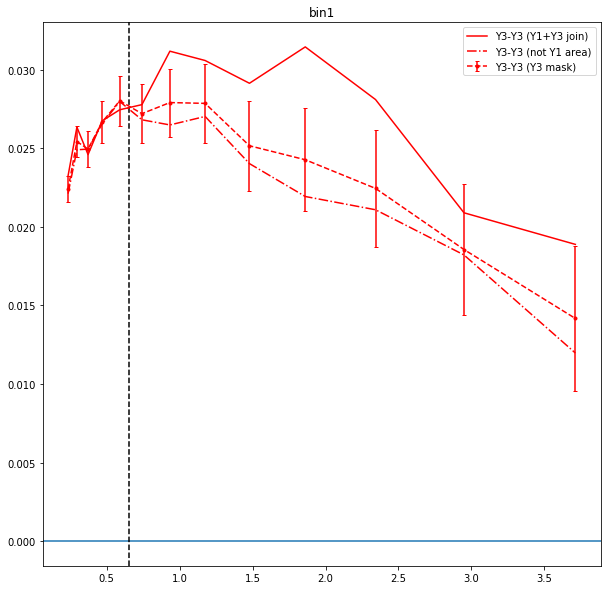

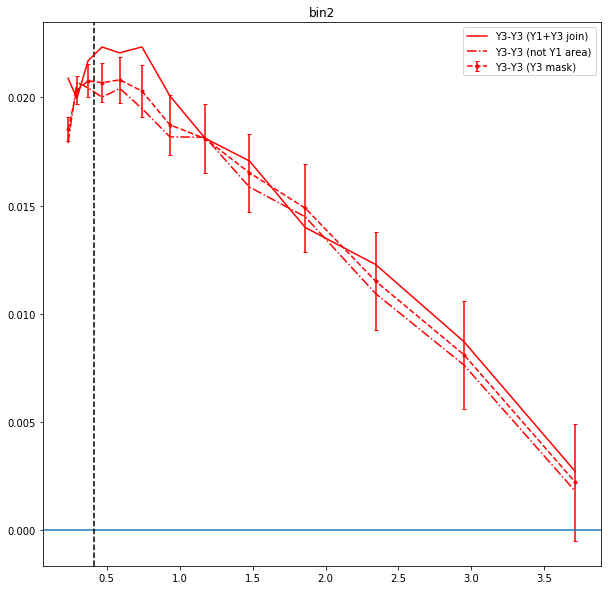

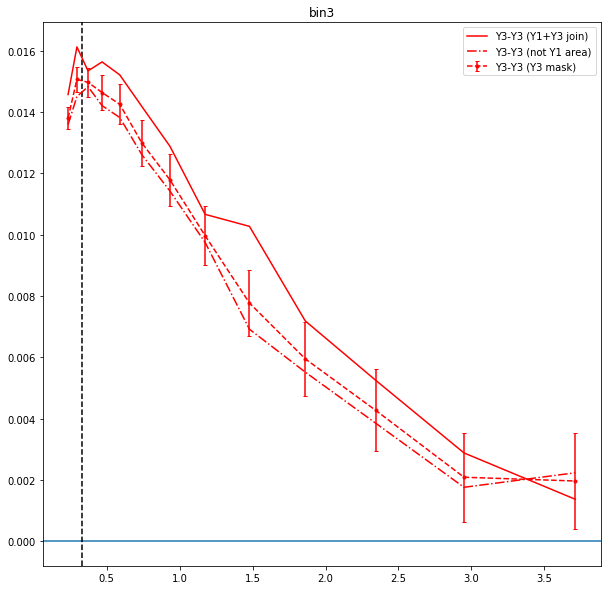

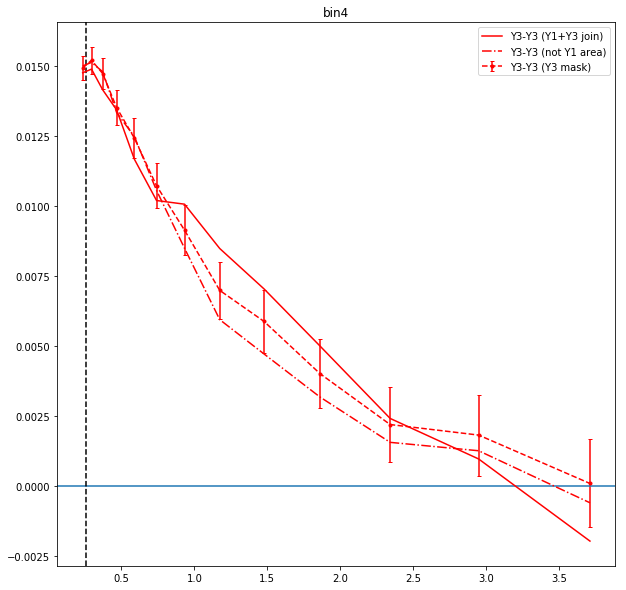

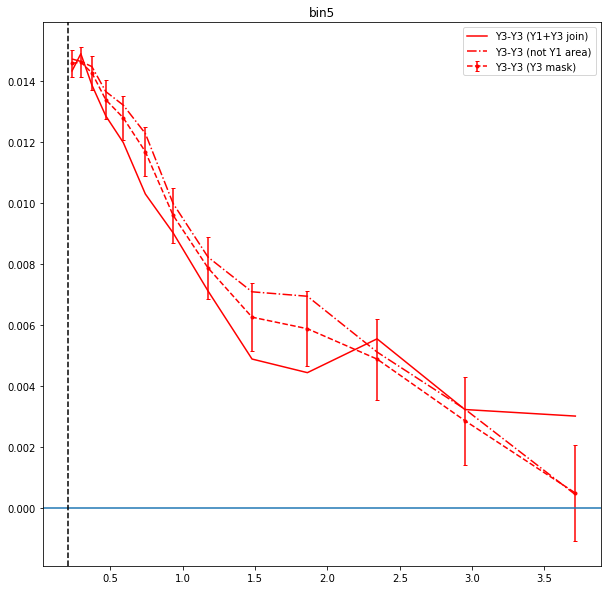

In [26]:
#Y3 only version of above plot
skip_bins = []
for ibin in xrange(nbins):
    if ibin in skip_bins:
        continue
        
    plt.figure(figsize=(10,10))
    plt.axhline(0)
    select = (off_dvec.bin1 == 1)*(off_dvec.bin2 == 1)
    off_theta = off_dvec.angle[select]/60.
    off_w = off_dvec.value[select]

    import healpy as hp 
    theta_min = hp.nside2resol(nside,arcmin=True)*2./60.
    
    y1_err = off_y1_dvec.get_error(ibin+1,ibin+1)
    y3_err = off_dvec.get_error(ibin+1,ibin+1)
    
    plt.axvline(sc[ibin]/60., color='k',ls='--')

    s = (theta > theta_min)

    
    plt.errorbar(theta[s], theta[s]*wthetay3[ibin+1][s], theta[s]*y3_err[s], 
                 capsize=2., fmt='.',  color='r', ls='--', 
                 label='Y3-Y3 (Y3 mask)')
    plt.plot(theta[s], theta[s]*wthetay3_jm[ibin+1][s], 
                 color='r', ls='-',  
                 label='Y3-Y3 (Y1+Y3 join)')
    plt.plot(theta[s], theta[s]*wthetay3_noty1[ibin+1][s], 
                 color='r', ls='-.',  
                 label='Y3-Y3 (not Y1 area)')

    plt.title('bin{0}'.format(ibin+1))
    plt.legend()
    plt.savefig('wtheta_y3only_bin{0}_{1}_with_y3noty1.png'.format(ibin+1, extra_label) )

4143.173796754788
1198.2687874785531
2944.9050092762345
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.48822679e-16
 1.69096456e-16 0.00000000e+00 0.00000000e+00 1.11903813e-16
 0.00000000e+00 2.55952506e-16 1.36619983e-16 0.00000000e+00
 0.00000000e+00 1.69548492e-16 1.84332255e-16 2.01928925e-16
 1.11541137e-16 1.24340658e-16 0.00000000e+00 0.00000000e+00]
masking covariance and vectors
cov_mat chi2
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21300690e-16
 0.00000000e+00 1.44593220e-16 0.00000000e+00 1.66075186e-16
 1.77514779e-16 1.90067531e-16 0.00000000e+00 0.00000000e+00
 2.39432618e-16 1.31023289e-16 0.00000000e+00 0.00000000e+00
 1.79448729e-16 0.00000000e+00 1.15998648e-16 0.00000000e+00]
masking covariance and vectors
cov_mat chi2
[1.33581505e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.21704126e-16 0.00000000e+00
 1.40065669e-16 1.50754104e-16 1.62999833e-16 0.00000000e+00
 0.00000000e+00 2.14067393e-16 0.00000000e+00 1.33252253e-16


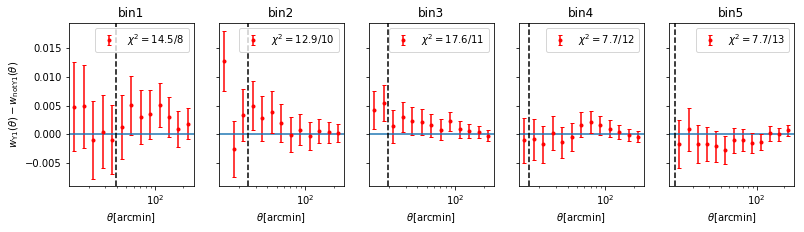

In [71]:
#Y3 only version of above plot (difference)

total_area = mask_y3_raw.area()
join_area  = mask_y3.area()
noty1_area = mask_y3_not_y1.area()
print(total_area)
print(join_area)
print(noty1_area)

cov_w = off_cov_full[-20*5:,-20*5:]

fig, axs= plt.subplots(1,5,figsize=(13,3), sharey=True)
axs = axs.flatten()

skip_bins = []
for ibin in xrange(nbins):
    if ibin in skip_bins:
        continue
        
    #plt.figure(figsize=(10,10))
    axs[ibin].axhline(0)

    import healpy as hp 
    theta_min = hp.nside2resol(nside,arcmin=True)*2./60.
    
    y3_err = off_dvec.get_error(ibin+1,ibin+1)
    
    axs[ibin].axvline(sc[ibin], color='k',ls='--')

    s = (theta > theta_min)
    
    wthetay3_bin = wthetay3[ibin+1]
    wthetay3_jm_bin = wthetay3_jm[ibin+1]
    wthetay3_noty1_bin = wthetay3_noty1[ibin+1]
    
    diff = wthetay3_jm_bin-wthetay3_noty1_bin
    diff_err = y3_err*np.sqrt((total_area/join_area)+(total_area/noty1_area))
    
    #get a chi2 from the full covariance
    cov_bin = cov_w[ibin*20:(ibin+1)*20, ibin*20:(ibin+1)*20]
    cov_diff = cov_bin*((total_area/join_area)+(total_area/noty1_area))
    print (np.sqrt(cov_diff.diagonal()) -  diff_err)/diff_err
    import misc
    angle_mask = (theta*60. > sc[ibin])
    chi2 = misc.calc_chi2(wthetay3_jm_bin, cov_diff, wthetay3_noty1_bin, mask=angle_mask )
    chi2_label = r'$\chi^2=$'+str(np.round(chi2,1))+'/'+str(sum(angle_mask))
    
    axs[ibin].errorbar(60.*theta[s], diff[s], diff_err[s],
                 capsize=2., fmt='.',  color='r', 
                 label=chi2_label, )
    axs[ibin].semilogx()
    if ibin == 0:
        axs[ibin].set_ylabel(r'$w_{\rm Y1}(\theta)- w_{\rm not Y1}(\theta)$')

    axs[ibin].set_title('bin{0}'.format(ibin+1))
    axs[ibin].set_xlabel(r'$\theta$'+'[arcmin]')
    axs[ibin].legend()
fig.savefig('wtheta_diff_y3only_allbins_{0}_with_y3noty1.png'.format(extra_label) )

In [42]:
#ratio of areas
print(join_area/total_area, noty1_area/total_area )

(0.289215187742575, 0.710784812257425)


In [47]:
#save the wthetas
np.save('wthetay1.npy',   wthetay1)
np.save('wthetay1_jm.npy',wthetay1_jm)
np.save('wthetay3.npy',   wthetay3)
np.save('wthetay3_jm.npy',wthetay3_jm)
np.save('wthetay1y3.npy', wthetay1y3)
np.save('wthetay3_noty1.npy', wthetay3_noty1 )
np.savetxt('theta.txt', theta)


In [ ]:
#save the galaxy maps
for ibin in xrange(nbins):
    galmaps = galmaps_all[ibin+1]
    for k in galmaps.keys()
        galmaps[k].save('galmap_{0}_bin{1}.fits.gz'.format(k,ibin+1))